In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
hf_spec = h5py.File("/home/pravn/Documents/Research Data/resampled_emission_spectra.h5", "r")
hf_grid = h5py.File("/home/pravn/Documents/Research Data/wl_grid.h5", "r")

wl_grid = np.array(hf_grid["wl_grid"])
df = pd.DataFrame(hf_spec["spectra"])

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
hf_spec.close()
hf_grid.close()

In [63]:
df_masked = df.loc[:,PLOT_MASK]
df_masked_np = df_masked.to_numpy()

In [6]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [7]:
distance_matrix = sd.pdist(df_masked_np, my_fastdtw) #O(MxN)

In [18]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [20]:
hf_dtwdistance = h5py.File("/home/pravn/Documents/Research Data/dtw_distances_halpha.h5","w")

In [21]:
hf_dtwdistance.create_dataset("dtw_distance", data=distance_matrix_square_form)
hf_dtwdistance.close()

In [27]:
distance_matrix_square_form

array([[ 0.        , 30.13772897, 39.35652421, ...,  1.64667516,
         1.3882707 ,  4.04934201],
       [30.13772897,  0.        ,  7.89733018, ..., 26.76797372,
        29.22981255, 20.14688527],
       [39.35652421,  7.89733018,  0.        , ..., 35.98676896,
        38.44860779, 29.81040761],
       ...,
       [ 1.64667516, 26.76797372, 35.98676896, ...,  0.        ,
         1.38817553,  2.69484773],
       [ 1.3882707 , 29.22981255, 38.44860779, ...,  1.38817553,
         0.        ,  3.4286624 ],
       [ 4.04934201, 20.14688527, 29.81040761, ...,  2.69484773,
         3.4286624 ,  0.        ]])

In [34]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

In [48]:
distance_matrix_square_form[:,0]

array([ 0.        , 30.13772897, 39.35652421, ...,  1.64667516,
        1.3882707 ,  4.04934201])

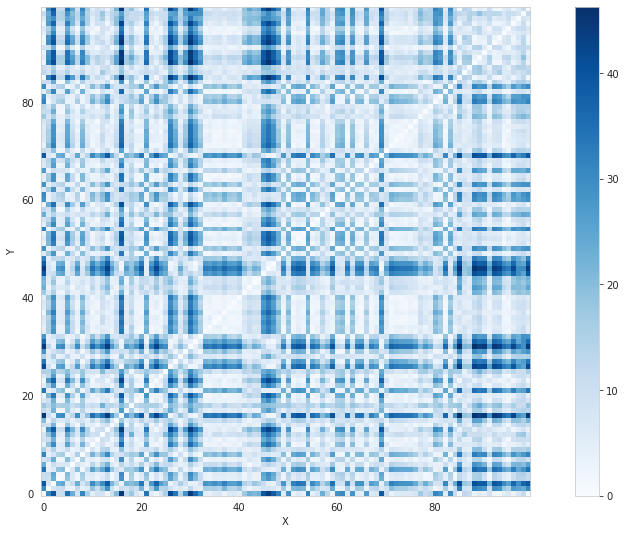

In [55]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [57]:
#agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([1, 2, 4, ..., 1, 1, 2])

In [58]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [59]:
score = silhouette_score(df_masked_np, agglom.labels_)
print(score)

0.3044376987506701


In [64]:
old_names = df_masked.columns.tolist()

In [68]:
new_names = wl_grid[PLOT_MASK].tolist()

In [70]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [72]:
df_masked.rename(columns=col_rename_dict, inplace=True)

In [73]:
df_masked

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
0,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,0.818449,...,0.798908,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837
1,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.059578,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276
2,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.956748,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347
3,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.945860,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340
4,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,0.903025,...,0.920758,0.925107,0.934469,0.943445,0.949600,0.948857,0.944906,0.948702,0.955197,0.953001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6972,0.979460,0.979947,0.992501,0.989477,0.973512,0.967220,0.973822,0.969585,0.959854,0.962128,...,0.983729,0.992850,1.004913,1.021605,1.029605,1.020435,1.005490,1.008604,1.042151,1.070625
6973,0.863882,0.848471,0.843037,0.840001,0.837331,0.834296,0.837569,0.835818,0.814332,0.811529,...,0.881433,0.880143,0.875100,0.903360,0.913392,0.900255,0.892303,0.890207,0.885781,0.886356
6974,0.774460,0.797341,0.842996,0.851695,0.832578,0.821339,0.809885,0.813631,0.819904,0.802070,...,0.771875,0.759515,0.782272,0.813831,0.816796,0.807716,0.802482,0.803715,0.810537,0.797218
6975,0.793960,0.789796,0.748887,0.756238,0.757121,0.718977,0.737649,0.747256,0.735109,0.722338,...,0.798911,0.804237,0.811593,0.803251,0.802970,0.821207,0.803905,0.772992,0.781017,0.804208


In [74]:
df_masked["label"] = pd.Series(agglom.labels_, index = df_masked.index)

In [75]:
df_masked

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
0,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,0.818449,...,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837,1
1,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,2
2,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,4
3,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,2
4,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,0.903025,...,0.925107,0.934469,0.943445,0.949600,0.948857,0.944906,0.948702,0.955197,0.953001,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6972,0.979460,0.979947,0.992501,0.989477,0.973512,0.967220,0.973822,0.969585,0.959854,0.962128,...,0.992850,1.004913,1.021605,1.029605,1.020435,1.005490,1.008604,1.042151,1.070625,3
6973,0.863882,0.848471,0.843037,0.840001,0.837331,0.834296,0.837569,0.835818,0.814332,0.811529,...,0.880143,0.875100,0.903360,0.913392,0.900255,0.892303,0.890207,0.885781,0.886356,1
6974,0.774460,0.797341,0.842996,0.851695,0.832578,0.821339,0.809885,0.813631,0.819904,0.802070,...,0.759515,0.782272,0.813831,0.816796,0.807716,0.802482,0.803715,0.810537,0.797218,1
6975,0.793960,0.789796,0.748887,0.756238,0.757121,0.718977,0.737649,0.747256,0.735109,0.722338,...,0.804237,0.811593,0.803251,0.802970,0.821207,0.803905,0.772992,0.781017,0.804208,1


In [76]:
df_sobject_ids = pd.read_csv("/home/pravn/Documents/Research Data/best_emission_candidates.csv", header=None)
df_sobject_ids.columns = ["sobject_id"]
df_masked = pd.concat([df_masked, df_sobject_ids], axis=1)
cols = df_masked.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_masked = df_masked[cols]

In [77]:
sobject_ids = df_sobject_ids["sobject_id"].to_numpy().tolist()

In [78]:
df_masked.head()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
0,131116000501262,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,...,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837,1
1,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,2
2,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,4
3,131118002401396,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,...,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,2
4,131118002901052,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,...,0.925107,0.934469,0.943445,0.949600,0.948857,0.944906,0.948702,0.955197,0.953001,2


In [81]:
df_masked["label"].value_counts()

1    3000
2    1848
3    1430
4     423
8     102
6      99
9      63
0       7
7       4
5       1
Name: label, dtype: int64

Int64Index([  97,   98,  127,  130,  362,  413,  422,  448,  451,  501,
            ...
            5274, 5278, 5306, 5556, 5796, 6314, 6318, 6495, 6603, 6655],
           dtype='int64', length=102)


<AxesSubplot:xlabel='Wavelength ($\\mathrm{\\AA}$)', ylabel='Flux [norm.]'>

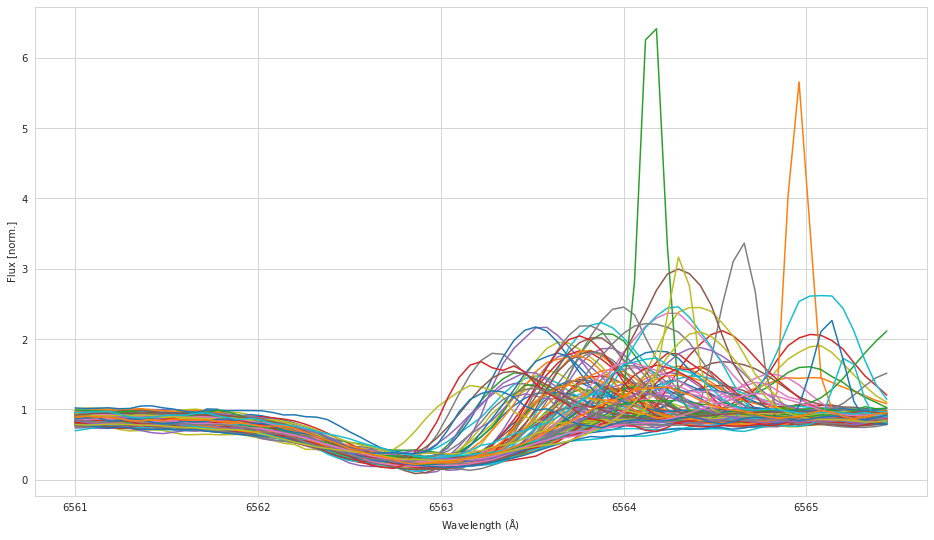

In [83]:
CLASS = 8
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
(df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(legend=False, xlabel = "Wavelength ($\mathrm{\AA}$)", ylabel= "Flux [norm.]")

#5293 is the errant inverse P-Cygni
#cross match against catalogs
#does it exist in the ctalog 
#4169 - get simbad 
#checknebular emissions flag 

In [85]:
df_masked.loc[3480,:"sobject_id"].astype(str)

sobject_id    190212001601342.0
Name: 3480, dtype: object